In [1]:
## Import the necessary libraries
import sqlite3
import pandas as pd
import os
import time
import numpy as np

In [2]:
# Paths
BASE_DIR = os.path.abspath("..")                      # github_repo/
DATA_DIR = os.path.join(BASE_DIR, "data", "raw")       # github_repo/data/raw
DB_PATH = os.path.join(BASE_DIR, "insurance.db")       # github_repo/insurance.db

In [3]:
# Connect back to the database
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

In [4]:
start_y = time.time()
y=pd.read_sql("SELECT * FROM y",conn)
end_y = time.time()
print(f"\nQuery returned {y.shape[0]:,} rows x {y.shape[1]} columns in {end_y - start_y:.2f} seconds")


Query returned 2,263,243 rows x 1 columns in 1.84 seconds


In [5]:
start_X = time.time()
X=pd.read_sql("SELECT * FROM X",conn)
end_X = time.time()
print(f"\nQuery returned {X.shape[0]:,} rows x {X.shape[1]} columns in {end_X - start_X:.2f} seconds")


Query returned 2,263,243 rows x 22 columns in 20.49 seconds


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

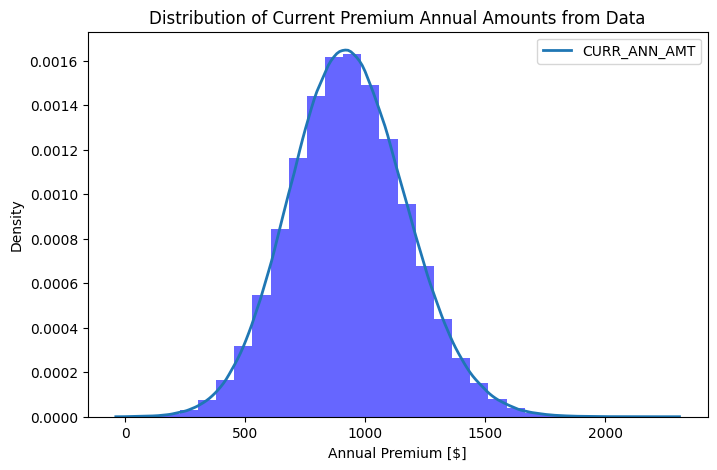

,CURR_ANN_AMT
count,2.263243e+06
mean,9.313080e+02
std,2.439470e+02
min,1.369660e-01
25%,7.649882e+02
50%,9.259615e+02
75%,1.092052e+03
max,2.269374e+03


In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(y,bins=30,density=True,alpha=0.6,color='blue')

# We're going to overlay a KDE (smooth curve)
import seaborn as sns
sns.kdeplot(y,color='red',linewidth=2)

plt.title("Distribution of Current Premium Annual Amounts from Data")
plt.xlabel("Annual Premium [$]")
plt.ylabel("Density")
plt.show()

y.describe()

In [8]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Add constant (intercept term)
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit Gaussian GLM with identity link
results = sm.GLM(
    y_train,
    X_train_sm,
    family = sm.families.Gaussian(sm.families.links.inverse_power())
).fit()

print(results.summary())

c:\Users\JDECKE46\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The inverse_power link alias is deprecated. Use InversePower instead. The inverse_power link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:           CURR_ANN_AMT   No. Observations:              1810594
Model:                            GLM   Df Residuals:                  1810577
Model Family:                Gaussian   Df Model:                           16
Link Function:          inverse_power   Scale:                          56332.
Method:                          IRLS   Log-Likelihood:            -1.2472e+07
Date:                Wed, 10 Sep 2025   Deviance:                   1.0199e+11
Time:                        20:23:42   Pearson chi2:                 1.02e+11
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05497
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [9]:
# Predict on a test set
y_pred = results.predict(X_test_sm)

model_mae = mean_absolute_error(y_test,y_pred)
model_rmse = np.sqrt(mean_squared_error(y_test,y_pred))

# Baseline: predict mean of y_train for everyone
baseline_pred = np.full_like(y_test,y_train.mean(),dtype=float)

baseline_mae = mean_absolute_error(y_test,baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test,baseline_pred))

print(f"Baseline MAE: {baseline_mae:.2f}")
print(f"Model MAE: {model_mae:.2f}")
print(f"MAE Gap: {baseline_mae - model_mae:.2f}")

print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Model RMSE: {model_rmse:.2f}")
print(f"RMSE Gap: {baseline_rmse - model_rmse:.2f}")

Baseline MAE: 194.10
Model MAE: 188.89
MAE Gap: 5.21
Baseline RMSE: 243.90
Model RMSE: 237.41
RMSE Gap: 6.49


Interpretability: If Model MAE / RMSE < Baseline, than the GLM is better than just guessing the average. The bigger the gap, the more predictive power you have

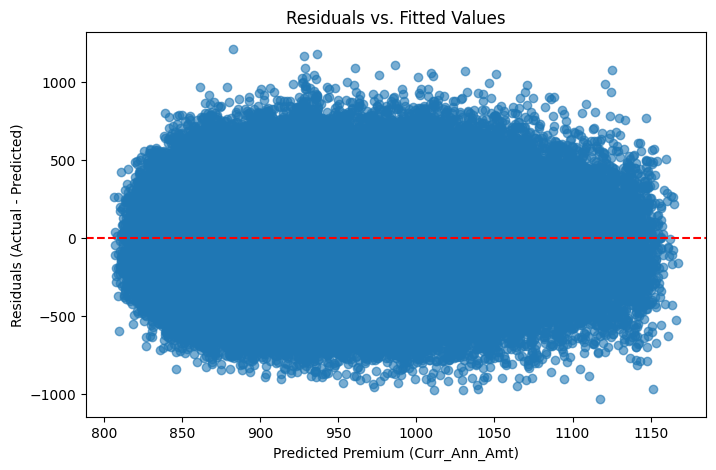

In [10]:
# Residual diagnostics
y_test_array = np.ravel(y_test)
y_pred_array = np.ravel(y_pred)

residuals = y_test_array - y_pred_array

plt.figure(figsize=(8,5))
plt.scatter(y_pred,residuals,alpha=0.6)
plt.axhline(0,color='red',linestyle='--')
plt.xlabel("Predicted Premium (Curr_Ann_Amt)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Fitted Values")
plt.show()

In [11]:
# Fit Gamma GLM with identity link
results = sm.GLM(
    y_train,
    X_train_sm,
    family = sm.families.Gamma(sm.families.links.inverse_power())
)
results = results.fit()

print(results.summary())

c:\Users\JDECKE46\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The inverse_power link alias is deprecated. Use InversePower instead. The inverse_power link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\JDECKE46\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


                 Generalized Linear Model Regression Results                  
Dep. Variable:           CURR_ANN_AMT   No. Observations:              1810594
Model:                            GLM   Df Residuals:                  1810577
Model Family:                   Gamma   Df Model:                           16
Link Function:          inverse_power   Scale:                        0.064717
Method:                          IRLS   Log-Likelihood:            -1.2517e+07
Date:                Wed, 10 Sep 2025   Deviance:                   1.3101e+05
Time:                        20:23:57   Pearson chi2:                 1.17e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05462
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [12]:
# Predict on a test set
y_pred = results.predict(X_test_sm)

model_mae = mean_absolute_error(y_test,y_pred)
model_rmse = np.sqrt(mean_squared_error(y_test,y_pred))

# Baseline: predict mean of y_train for everyone
baseline_pred = np.full_like(y_test,y_train.mean(),dtype=float)

baseline_mae = mean_absolute_error(y_test,baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test,baseline_pred))

print(f"Baseline MAE: {baseline_mae:.2f}")
print(f"Model MAE: {model_mae:.2f}")
print(f"MAE Gap: {baseline_mae - model_mae:.2f}")

print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Model RMSE: {model_rmse:.2f}")
print(f"RMSE Gap: {baseline_rmse - model_rmse:.2f}")

Baseline MAE: 194.10
Model MAE: 188.89
MAE Gap: 5.21
Baseline RMSE: 243.90
Model RMSE: 237.41
RMSE Gap: 6.49


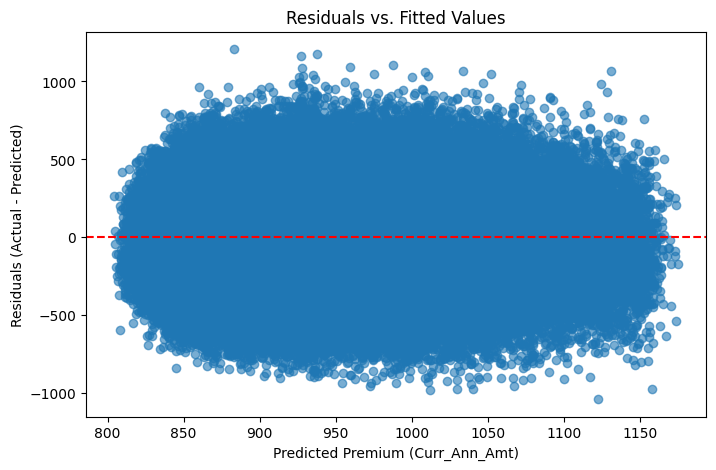

In [13]:
# Residual diagnostics
y_test_array = np.ravel(y_test)
y_pred_array = np.ravel(y_pred)

residuals = y_test_array - y_pred_array

plt.figure(figsize=(8,5))
plt.scatter(y_pred,residuals,alpha=0.6)
plt.axhline(0,color='red',linestyle='--')
plt.xlabel("Predicted Premium (Curr_Ann_Amt)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Fitted Values")
plt.show()

Okay so we can see that there is a huge range of residual values. To combat this, let's try implementing nonlinear terms.